In [1]:
import hope
hope.config.optimize = True
hope.config.keeptemp = True
import numpy as np
from matplotlib import pyplot as plt
import warnings
# warnings.filterwarnings("ignore", category=UserWarning) 


%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Python Optimizations

## Avoid memory allocations

**zombie apocalypse modeling** from http://wiki.scipy.org/Cookbook/Zombie_Apocalypse_ODEINT

In [2]:
from scipy.integrate import odeint

P, d, B, G, A = 0, 0.0001, 0.0095, 0.0001, 0.0001

def f_nat(y, t):
    dy = np.empty(3)
    dy[0] = P - B*y[0]*y[1] - d*y[0]
    dy[1] = B*y[0]*y[1] + G*y[2] - A*y[0]*y[1]
    dy[2] = d*y[0] + A*y[0]*y[1] - G*y[2]
    return dy

y0, t = np.array([500., .001, 0.]), np.linspace(0, 5., 1000)

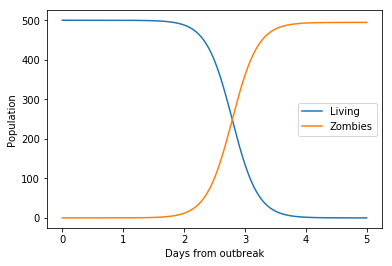

In [3]:
soln = odeint(f_nat, y0, t)
plt.figure()
plt.plot(t, soln[:, 0], label='Living')
plt.plot(t, soln[:, 1], label='Zombies')
plt.xlabel('Days from outbreak')
plt.ylabel('Population')
plt.legend(loc=0)
plt.show()

In [4]:
@hope.jit
def f_hope(y, t, P, d, B, G, A):
    dy = np.empty(3)
    dy[0] = P - B*y[0]*y[1] - d*y[0]
    dy[1] = B*y[0]*y[1] + G*y[2] - A*y[0]*y[1]
    dy[2] = d*y[0] + A*y[0]*y[1] - G*y[2]
    return dy

@hope.jit
def f_opt(y, t, dy, P, d, B, G, A):
    dy[0] = P - B*y[0]*y[1] - d*y[0]
    dy[1] = B*y[0]*y[1] + G*y[2] - A*y[0]*y[1]
    dy[2] = d*y[0] + A*y[0]*y[1] - G*y[2]
    return dy

dy = np.empty(3)
print("native python")
%timeit odeint(f_nat, y0, t)
print("hope")
%timeit odeint(f_hope, y0, t, args=(P, d, B, G, A))
print("hope without allocation")
%timeit odeint(f_opt, y0, t, args=(dy, P, d, B, G, A))

native python
1.53 ms ± 29.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
hope
266 µs ± 24.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
hope without allocation
237 µs ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Approximate expensive functions

### tanh

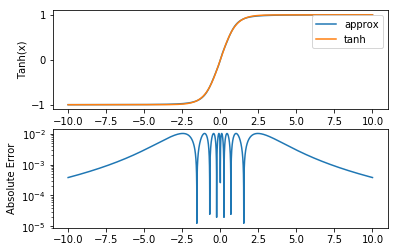

In [5]:
def tanhpoly(x):
    a = np.fabs(x)
    b = 1.26175667589988239 + a * (-0.54699348440059470 + a * 2.66559097474027817)
    return (b * x) / (b * a + 1)

x = np.linspace(-10, 10, 10000)

plt.subplot(2, 1,1)
plt.plot(x, tanhpoly(x), label="approx")
plt.plot(x, np.tanh(x), label="tanh")
plt.ylabel('Tanh(x)')
plt.legend()

plt.subplot(2, 1,2)
plt.semilogy()
plt.plot(x, np.fabs(tanhpoly(x)- np.tanh(x)))
plt.ylabel('Absolute Error')
plt.show()

In [10]:
@hope.jit
def tanh_hope(x, y):
    y[:] = np.tanh(x)

@hope.jit
def tanhpoly_hope(x, y):
    a = np.fabs(x)
    b = 1.26175667589988239 + a * (-0.54699348440059470 + a * 2.66559097474027817)
    y[:] = (b * x) / (b * a + 1)

y = np.empty_like(x)

print("numpy tanh")
%timeit tanh_hope(x, y)
print("polynomial approximation")
%timeit tanhpoly_hope(x, y)

numpy tanh
1.32 µs ± 541 ns per loop (mean ± std. dev. of 7 runs, 1 loop each)
polynomial approximation
The slowest run took 6.28 times longer than the fastest. This could mean that an intermediate result is being cached.
1.12 µs ± 1.12 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### exp

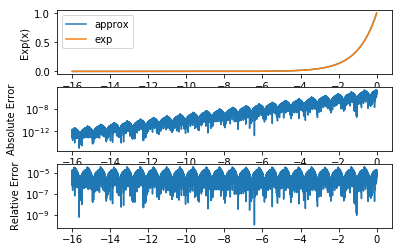

In [7]:
@hope.jit
def expapprox(x, y):
    y[:] = hope.exp(x)
    return y

x = np.linspace(-16, 0, 10000)
y = np.empty_like(x)

plt.subplot(3, 1, 1)
plt.plot(x, expapprox(x, y), label="approx")
plt.plot(x, np.exp(x), label="exp")
plt.ylabel('Exp(x)')
plt.legend()

plt.subplot(3, 1, 2)
plt.semilogy()
plt.plot(x, np.fabs(expapprox(x, y)- np.exp(x)) + np.finfo(np.float64).resolution)
plt.ylabel('Absolute Error')

plt.subplot(3, 1, 3)
plt.semilogy()
plt.plot(x, np.fabs(expapprox(x, y)- np.exp(x)) / np.exp(x) + np.finfo(np.float64).resolution)
plt.ylabel('Relative Error')
plt.show()

In [8]:
@hope.jit
def exp_hope(x, y):
    y[:] = np.exp(x)

@hope.jit
def exppow_hope(x, y):
    y[:] = hope.exp(x)
    
y = np.empty_like(x)

print("numpy exp")
%timeit exp_hope(x, y)
print("polynomial exp")
%timeit exppow_hope(x, y)

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-8-24ec4749f7ad>, line 11)

## Avoid floating point powers

In [ ]:
def native_pow(x, y):
    y[:] = 16.11 - 3./(3. * x**2) + 0.5 *(0.4651 * x**-3 + 43.44) * x**-3 + 4. * x**-4
                                              
@hope.jit
def float_pow(x, y):
    y[:] = 16.11 - 3./(3. * x**2.) + 0.5 *(0.4651 * x**-3. + 43.44) * x**-3. + 4. * x**-4.

@hope.jit
def int_pow(x, y):
    y[:] = 16.11 - 3./(3. * x**2) + 0.5 *(0.4651 * x**-3 + 43.44) * x**-3 + 4. * x**-4

x = np.linspace(-10, 10, 10000)
y = np.empty_like(x)

print("native python")
%timeit native_pow(x, y)
print("hope float power")
%timeit float_pow(x, y)
print("hope integer power")
%timeit int_pow(x, y)

## Improve interpolation

In [9]:
X = np.empty(1100)
X[:1024] = np.linspace(-1., 1., 1024)
X[1024:] = X[1023] + X[1:77] - X[0]
SN = np.sin(X)
CN = np.cos(X)

@hope.jit
def approx(x, sn, cn, X, SN, CN):
    for i in range(100):
        sn[i] = np.interp(x[i], X, SN)
        cn[i] = np.interp(x[i], X, CN)

@hope.jit
def approx_opt(x, sn, cn, X, SN, CN):
    for i in range(100):
        f = (x[i] - X[0]) / (X[1024] - X[0]) * 1024.
        g = np.floor(f)
        j = np.int_(g)
        a = f - g
        sn[i] = (1 - a) * SN[j] + a * SN[j + 1]
        cn[i] = (1 - a) * CN[j] + a * CN[j + 1]

x = 2. * random_sample(100) - 1
sn = np.empty_like(x)
cn = np.empty_like(x)

%timeit approx(x, sn, cn, X, SN, CN)
%timeit approx_opt(x, sn, cn, X, SN, CN)

9.79 µs ± 1.09 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
The slowest run took 6.76 times longer than the fastest. This could mean that an intermediate result is being cached.
1.91 µs ± 1.99 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
